In [77]:
!tensorboard --logdir=logs/ --host localhost --port 8088

^C


In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

from skimage.io import imread, imshow

### Data Preprocessing

In [2]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    # Convert mask to grayscale
    input_mask = tf.image.rgb_to_grayscale(input_mask)

    return input_image, input_mask 

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
  
    return input_image, input_mask

In [37]:
X_train = []
Y_train = []
X_test = []

# Conta a quantidade de imagens de test
n_test = len(os.listdir(TEST_PATH+'images'))
n_train = len(os.listdir(TRAIN_PATH+'images'))


X_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print(X_train.shape)

# Load test images
for i in tqdm(range(n_test)):
    img = imread(TEST_PATH+'images/'+os.listdir(TEST_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.flip_left_right(img)
    X_test[i] = img

# Load train images
for i in tqdm(range(n_train)):
    img = imread(TRAIN_PATH+'images/'+os.listdir(TRAIN_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(TRAIN_PATH+'labels/'+os.listdir(TRAIN_PATH+'labels')[i])
    img, mask = resize(img, mask)
    img, mask = augment(img, mask)
    X_train[i] = img
    Y_train[i] = mask
    

(810, 128, 128, 3)


100%|██████████| 810/810 [00:12<00:00, 65.11it/s]


### Model

In [5]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    return x

In [6]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

In [7]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [8]:
def build_unet_model():
    # Input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalizing the inputs

    # Encoder
    c1, p1 = downsample_block(s, 16)
    c2, p2 = downsample_block(p1, 32)
    c3, p3 = downsample_block(p2, 64)
    c4, p4 = downsample_block(p3, 128)

    # Bottleneck
    bn = double_conv_block(p4, 256)

    # Decoder
    u6 = upsample_block(bn, c4, 128)
    u7 = upsample_block(u6, c3, 64)
    u8 = upsample_block(u7, c2, 32)
    u9 = upsample_block(u8, c1, 16)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(u9)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [9]:
model = build_unet_model()
# model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]  

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting


In [78]:
# Params
BATCH_SIZE=16
EPOCHS=2

#Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="model_for_nuclei.keras", save_best_only=True, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9896 - loss: 0.0335
Epoch 1: val_loss improved from inf to 0.03678, saving model to model_for_nuclei.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 634ms/step - accuracy: 0.9896 - loss: 0.0335 - val_accuracy: 0.9894 - val_loss: 0.0368
Epoch 2/2
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9900 - loss: 0.0325
Epoch 2: val_loss improved from 0.03678 to 0.02979, saving model to model_for_nuclei.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 651ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9901 - val_loss: 0.0298


### Predictions

In [44]:
# Val data
VAL_PATH = 'data/validation/'

n_val = len(os.listdir(VAL_PATH+'images'))

X_val = np.zeros((n_val, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((n_val, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Load val images
for i in tqdm(range(n_val)):
    img = imread(VAL_PATH+'images/'+os.listdir(VAL_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(VAL_PATH+'labels/'+os.listdir(VAL_PATH+'labels')[i])
    img, mask = resize(img, mask)
    X_val[i] = img
    Y_val[i] = mask

100%|██████████| 200/200 [00:03<00:00, 66.51it/s]


In [63]:
# Predict on val, train and test
preds_val = model.predict(X_val, verbose=1)
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.2).astype(np.uint8)
preds_train_t = (preds_train > 0.2).astype(np.uint8)
preds_test_t = (preds_test > 0.2).astype(np.uint8)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step
[[[[1.24524280e-01]
   [5.06532118e-02]
   [2.97946576e-02]
   ...
   [4.55792295e-04]
   [3.54908756e-03]
   [1.67885683e-02]]

  [[6.57580271e-02]
   [1.82046313e-02]
   [8.61723348e-03]
   ...
   [4.71184394e-05]
   [4.72989224e-04]
   [4.15682979e-03]]

  [[4.03128192e-02]
   [8.25070124e-03]
   [2.38418812e-03]
   ...
   [1.61180305e-05]
   [1.53241621e-04]
   [1.35099993e-03]]

  ...

  [[2.37044902e-03]
   [1.81503565e-04]
   [1.08828295e-04]
   ...
   [7.76893012e-06]
   [3.32588861e-05]
   [1.25828630e-03]]

  [[1.28596313e-02]
   [1.85820926e-03]
   [2.83558504e-04]
   ...
   [6.78670694e-05]
   [8.89117000e-05]
   [5.54582663e-03]]

  [[3.83182392e-02]
   [1.81586761e-02]
   [1.08527532e-02]
   ...
   [5.34476305e-04]
   [2.10036268e-03]
   [3.93281877e-02]]]


 [[[2.18154013e-01]
   [1.11419611e-01]
   [8.12285915e-02]
   ...
   [1.98397291e-04]
   [2.02328

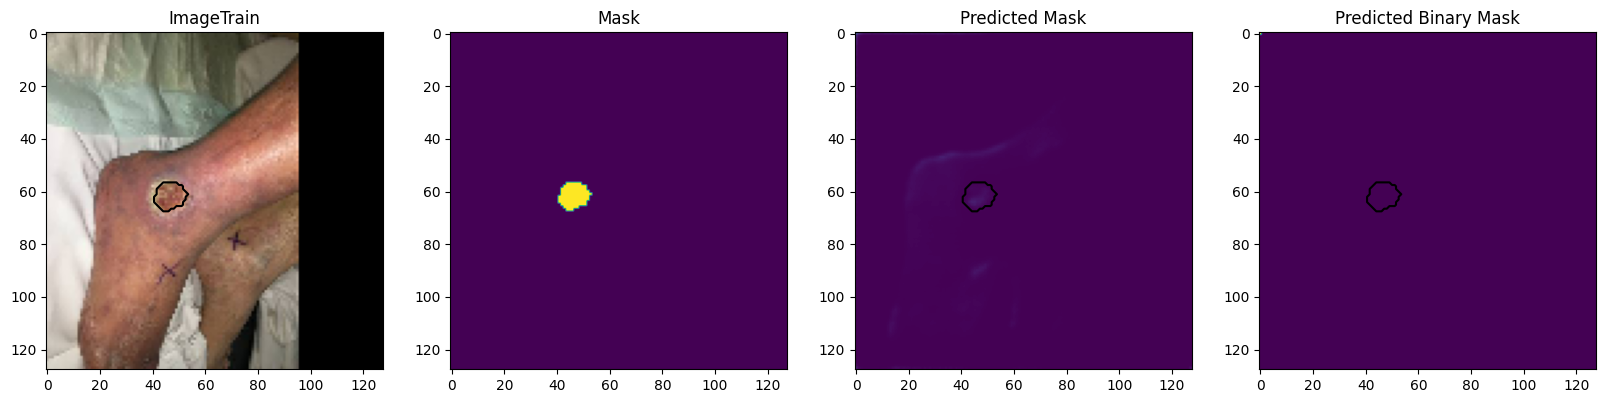

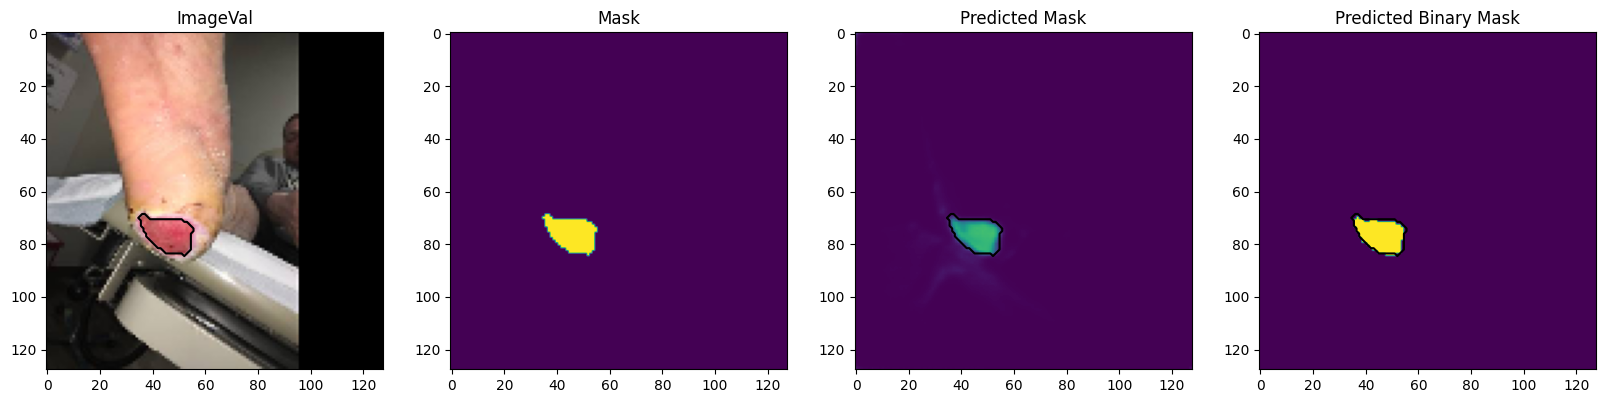

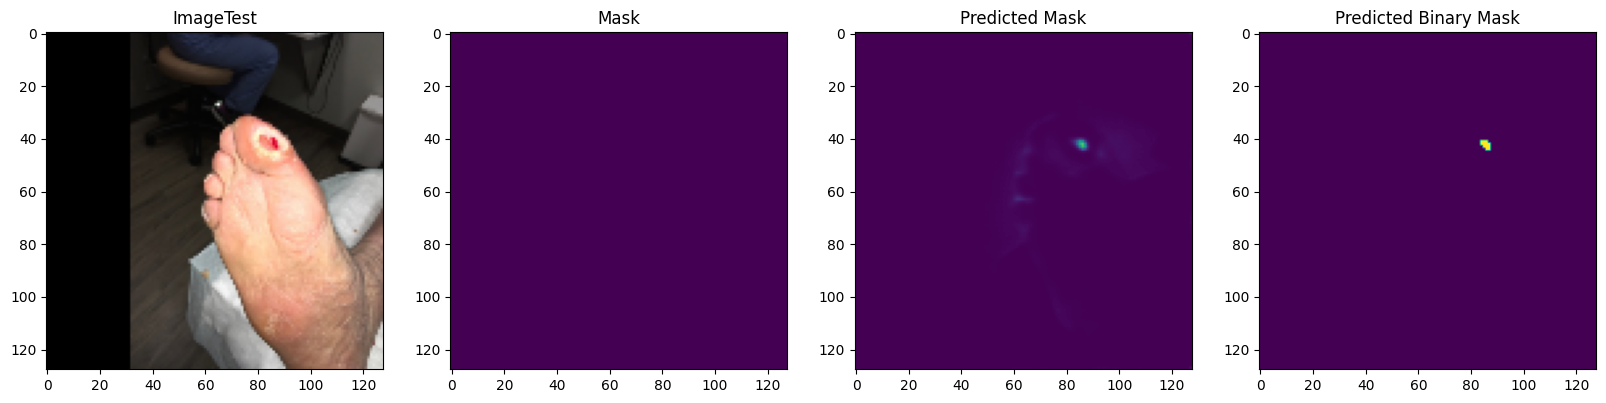

In [62]:
# Plot the results
def plot_sample(title, X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image' + title)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary Mask')

# Check if training data looks all right
plot_sample("Train", X_train, Y_train, preds_train, preds_train_t)

# Check if valid data looks all right
plot_sample("Val", X_val, Y_val, preds_val, preds_val_t)

# Check if test data looks all right
Y_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
plot_sample("Test", X_test, Y_test, preds_test, preds_test_t)

## Evaluate

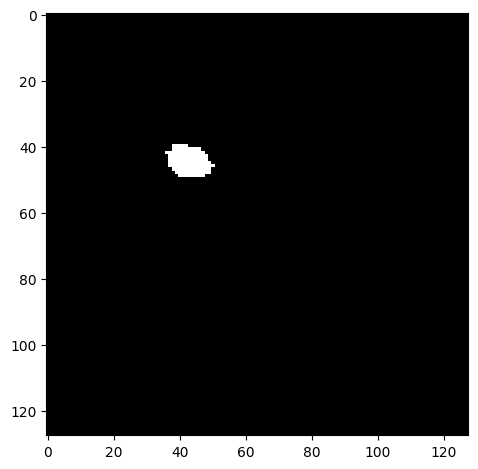

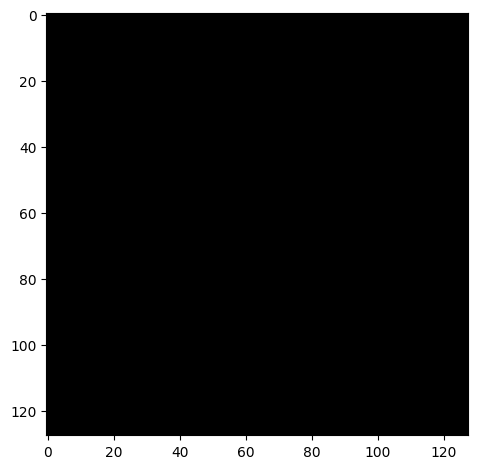

0.006591796875


In [74]:
ix = 4
deviation = np.mean(np.abs(Y_val[ix] ^ preds_test_t[ix]))
imshow(Y_val[ix].squeeze())
plt.show()
imshow(preds_val_t[ix].squeeze())
plt.show()
print(deviation)